# CNN Model

For the construction of the first model, the process began by applying a simple convolutional neural network with three convolutional layers. Each of these layers is followed by a ReLU activation layer and a MaxPooling layer, which will group information from the nearest neighbors within the feature map. This way, a set with the most important features identified by the convolution filter is obtained, with the advantage of further reducing the volume of information. The output is flattened and passed as inputs to linear layers responsible for adjusting the weights of the neurons until providing the correct classification for the observation.

### Loading and preparation of the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from utils import check_device, make_dataset
from models import cnn_model as cnn
from visualization import visualize

In [2]:
device = check_device.set_device()
print(device)

cuda


In [3]:
path_dir = "../../kaggle/pneumoniaDataset/chest_xray"

train_data_dir, test_data_dir = make_dataset.path_dataset(path_dir)

The path ../../kaggle/pneumoniaDataset/chest_xray is valid.


In [4]:
images, labels = make_dataset.load_chest_xray_data( train_data_dir )
images_test, labels_test = make_dataset.load_chest_xray_data( test_data_dir )

In [5]:
# To convert to a NumPy array
# Training test
np_images = np.array(images, dtype=object)
np_labels = np.array(labels, dtype=object)
# Testing set
np_images_test = np.array(images_test, dtype=object)
np_labels_test = np.array(labels_test, dtype=object)

### Image preprocessing

In [6]:
# Preprocessing of images
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((256, 256)),
                                transforms.RandomApply(torch.nn.ModuleList([
                                    transforms.RandomRotation(degrees=25),]), p=0.5),
                                transforms.RandomCrop((224, 224)),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

transform_test = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

# The data sets (training and test) are extracted using the torchvision.datasets library.
train_dataset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_data_dir, transform=transform_test)


# The training set is divided into training data and validation data.
train_set, validation_set = random_split(train_dataset, 
                                                 (int(len(train_dataset) * 0.8)+1,
                                                 int(len(train_dataset) * 0.2)))

# The dataset is wrapped in an iterable for better access to samples in the training set.
batch_size = 64
train_dataloader = DataLoader( train_set, batch_size=batch_size, shuffle=True )
valid_dataloader = DataLoader( validation_set, batch_size=batch_size, shuffle=True )
test_dataloader = DataLoader( test_dataset, batch_size=batch_size)

### Definition of the CNN architecture

Application of weights to the loss function to prevent biases in the model:

In [7]:
normal, virus, bacteria, total = visualize.count_labels(labels)

# class weights inversely proportional to frequency
class_weights = 1.0 / torch.tensor([normal, virus, bacteria], dtype=torch.float)

# Normalize weights to sum up to 1
class_weights = class_weights / class_weights.sum()

# Create the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [8]:
class CNN_NeuralNetwork(nn.Module):
    def __init__(self, in_channels=1, out_channels_1=32, out_channels_2=64):
        super(CNN_NeuralNetwork, self).__init__()
        self.conv2d_stack = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels_1,
                      kernel_size=3,
                      padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(out_channels_1),
            nn.Conv2d(in_channels=out_channels_1,
                      out_channels=out_channels_2,
                      kernel_size=3,
                      padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(out_channels_2),
            nn.Conv2d(in_channels=out_channels_2,
                      out_channels=out_channels_2*2,
                      kernel_size=3,
                      padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(out_channels_2*2),
        )
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear((out_channels_2*2)*32*32, 64),  # (in_features, out_features)  
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3),  # n inputs and 3 possible outputs corresponding to the labels.
        )

    def forward(self, x):
        x = self.conv2d_stack(x)
        x = self.flatten(x)                          
        logits = self.linear_stack(x)
        return logits


In [9]:
# Model instance
cnn_model = CNN_NeuralNetwork().to(device)
cnn_model

CNN_NeuralNetwork(
  (conv2d_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=131072, out_features=64, bias=True)
    (1): ReL

### Hyperparameters

For training, the samples have been processed in batches of 64, using a learning rate of 0.001. The dataset will be iterated over a total of 50 times unless it stops prematurely upon observing that the model does not improve after a given number of epochs.

In [10]:
learning_rate = 0.001  # 1e-3
epochs = 50

In [11]:
# Initialize the loss function
weight=class_weights
weight = weight.to(device)

train_criterion = nn.CrossEntropyLoss(weight)
test_criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

### Train Loop

In [12]:
hist = cnn.train_model(cnn_model, train_dataloader, valid_dataloader, train_criterion, optimizer, epochs)

Epoch 1 / 50 
-------------------------------
loss: 1.107273  [    0/ 4186]
loss: 0.736456  [ 2048/ 4186]
loss: 0.732696  [ 4096/ 4186]
Test Error: 
 Accuracy: 50.3%, Avg loss: 1.313889 

Epoch 2 / 50 
-------------------------------
loss: 0.552640  [    0/ 4186]
loss: 0.658612  [ 2048/ 4186]
loss: 0.581702  [ 4096/ 4186]
Test Error: 
 Accuracy: 76.3%, Avg loss: 0.549703 

Epoch 3 / 50 
-------------------------------
loss: 0.502190  [    0/ 4186]
loss: 0.503854  [ 2048/ 4186]
loss: 0.579394  [ 4096/ 4186]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.527473 

Epoch 4 / 50 
-------------------------------
loss: 0.580178  [    0/ 4186]
loss: 0.794144  [ 2048/ 4186]
loss: 0.530904  [ 4096/ 4186]
Test Error: 
 Accuracy: 71.6%, Avg loss: 0.531741 

Epoch 5 / 50 
-------------------------------
loss: 0.501038  [    0/ 4186]
loss: 0.492831  [ 2048/ 4186]
loss: 0.530485  [ 4096/ 4186]
Test Error: 
 Accuracy: 73.9%, Avg loss: 0.515121 

Epoch 6 / 50 
-------------------------------
loss: 0.530935

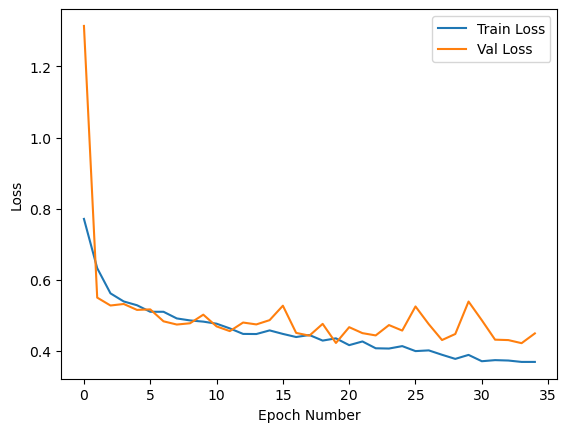

In [13]:
visualize.plot_loss_history(hist)

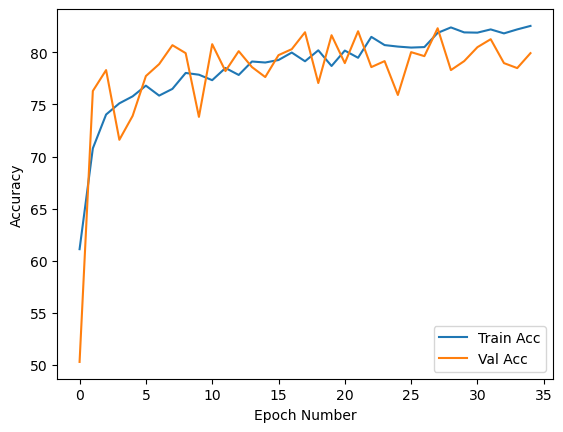

In [14]:
visualize.plot_accuracy_history(hist)

## Testing

Reading the stored model and performing the tests.

In [15]:
checkpoint = torch.load('../models/cnn_basic_1_checkpoint.pth.tar')

In [16]:
print(checkpoint['epoch'])
print(checkpoint['accuracy'])

28
82.31357552581262


In [17]:
# Loading the model
cnn_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [18]:
# Test
accuracy, test_loss, true_labels, pred_labels = cnn.test_model(test_dataloader, cnn_model, test_criterion)

Test evaluation:
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.406864 

Done!


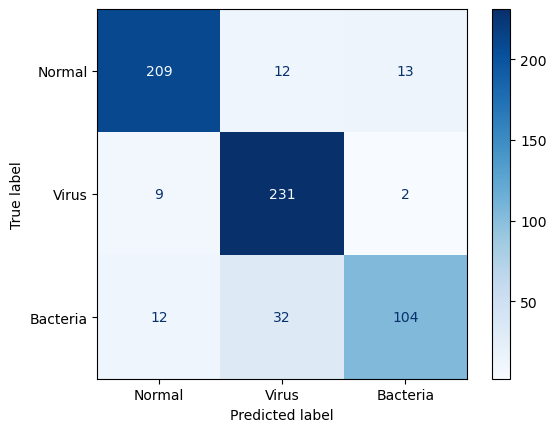

In [19]:
cm = confusion_matrix(true_labels, pred_labels)

classes=['Normal', 'Virus', 'Bacteria']
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cmDisplay.plot(cmap="Blues")
plt.show()

In [20]:
print(classification_report(true_labels,pred_labels, target_names=classes))

              precision    recall  f1-score   support

      Normal       0.91      0.89      0.90       234
       Virus       0.84      0.95      0.89       242
    Bacteria       0.87      0.70      0.78       148

    accuracy                           0.87       624
   macro avg       0.87      0.85      0.86       624
weighted avg       0.87      0.87      0.87       624



## Image classifier

Random images are chosen to visually verify some results of the model.

In [21]:
im_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

image: BACTERIA-9242636-0003.jpeg
pred: PNEUMONIA_VIRUS
-Softmax: 
Normal: 0.0001 | Bacteria: 0.9934 | Virus: 0.0065


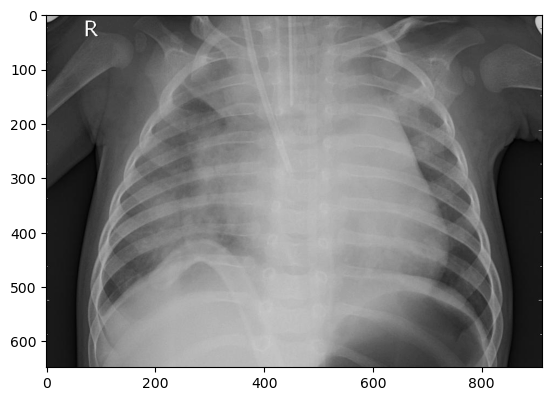

In [22]:
# Check a random sample
model=cnn_model
classes = ['NORMAL', 'PNEUMONIA_VIRUS', 'PNEUMONIA_BACTERIA']

visualize.classify_random_image(model, im_transform, '../../kaggle/pneumoniaDataset/chest_xray/test/', classes, device)

image: NORMAL-9708691-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 0.9874 | Bacteria: 0.0001 | Virus: 0.0125


image: BACTERIA-9050379-0001.jpeg
pred: PNEUMONIA_VIRUS
-Softmax: 
Normal: 0.0004 | Bacteria: 0.9102 | Virus: 0.0893


image: VIRUS-3768496-0001.jpeg
pred: PNEUMONIA_BACTERIA
-Softmax: 
Normal: 0.0072 | Bacteria: 0.2975 | Virus: 0.6952


image: BACTERIA-9364007-0003.jpeg
pred: PNEUMONIA_VIRUS
-Softmax: 
Normal: 0.0625 | Bacteria: 0.8167 | Virus: 0.1208


image: NORMAL-3837280-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 1.0000 | Bacteria: 0.0000 | Virus: 0.0000


image: NORMAL-6195450-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 1.0000 | Bacteria: 0.0000 | Virus: 0.0000


image: BACTERIA-8285922-0005.jpeg
pred: PNEUMONIA_VIRUS
-Softmax: 
Normal: 0.0029 | Bacteria: 0.9323 | Virus: 0.0647


image: NORMAL-115218-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 0.9676 | Bacteria: 0.0171 | Virus: 0.0153


image: NORMAL-2870844-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 0.9998 | Bacteria: 0.0000 | V

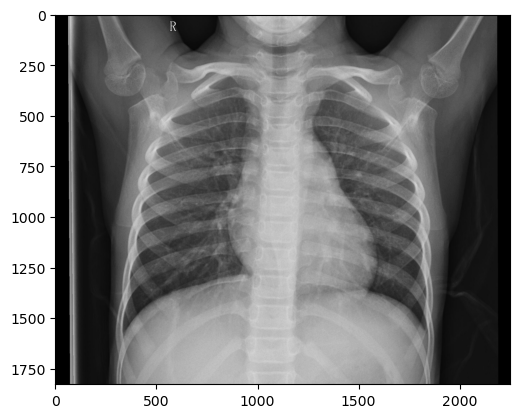

In [23]:
# Check random samples
for i in range(10):
    visualize.classify_random_image(model, im_transform, '../../kaggle/pneumoniaDataset/chest_xray/test/', classes, device)
    print("\n")